# Configuración entorno de ejecución

In [ ]:
#@title Instalación de librerias
!pip install pytorch_pretrained_bert
!pip install transformers
!pip install jsonlines

     |████████████████████████████████| 123 kB 35.6 MB/s 
     |████████████████████████████████| 132 kB 91.5 MB/s 
     |████████████████████████████████| 79 kB 11.3 MB/s 
     |████████████████████████████████| 8.7 MB 72.5 MB/s 
     |████████████████████████████████| 138 kB 77.9 MB/s 
     |████████████████████████████████| 127 kB 80.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.2 MB 32.2 MB/s 
     |████████████████████████████████| 596 kB 66.7 MB/s 
     |████████████████████████████████| 6.6 MB 76.0 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/

In [ ]:
#@title Carga de librerias
#Image
from PIL import Image , ImageFile
import torchvision.transforms as transforms
import pickle
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms

#Text
from transformers import BertTokenizer
from transformers import BertModel as BertModel2
from transformers import BertConfig

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
import argparse
import functools
from torch.utils.data import DataLoader

import json
import numpy as np
import jsonlines



import argparse
import numpy as np
from collections import Counter
from tqdm import tqdm
import shutil
from sklearn.metrics import f1_score
import json
import os




# 1. Unsupervised Data Augmentation


Qizhe Xie, Zihang Dai, Eduard Hovy, Minh-Thang Luong, and Quoc V. Le. 2020. Unsupervised data augmentation for consistency training. In Proceedings of the 34th International Conference on Neural Information Processing Systems (NIPS'20). Curran Associates Inc., Red Hook, NY, USA, Article 525, 6256–6268.

https://proceedings.neurips.cc/paper/2020/file/44feb0096faa8326192570788b38c1d1-Paper.pdf

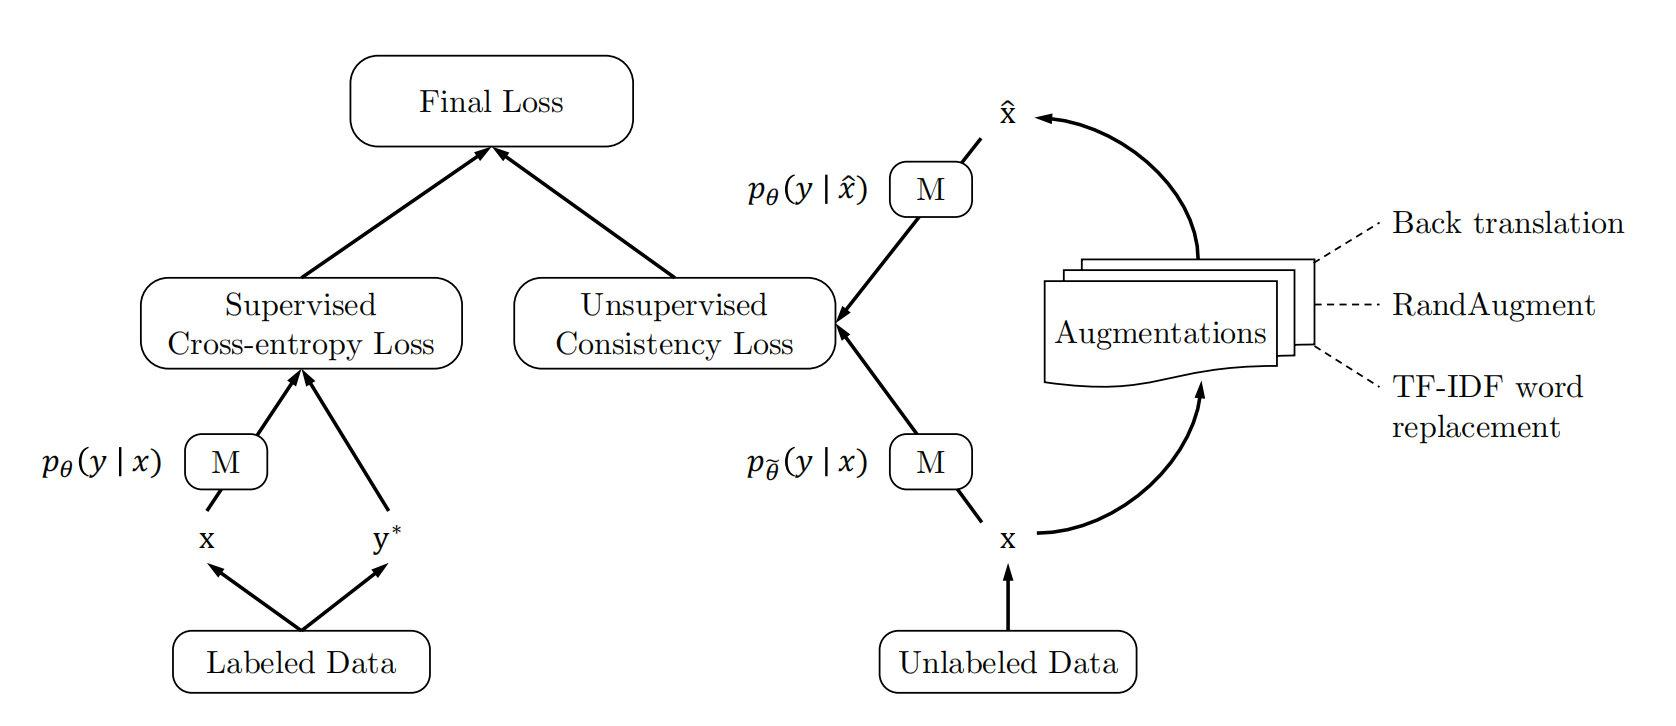

\begin{align}
\sum_{(x,y^*)\in L}-log(p_{\theta}(y^*|x)) +\lambda  \sum_{x\in U}\mathcal{D}(p_{\hat{\theta}}(y|x)\parallel p_{\theta}(y|\hat{x}))
\end{align}

Divergencia de Kullback-Leibler
\begin{align}
\mathcal{D}(p\parallel q)=-\sum_{c}P(c)\log\frac{Q(c)}{P(c)}
\end{align}

In [ ]:
def kl_divergence_with_logits(p_logits, q_logits):
    p = F.softmax(p_logits,dim=-1)
    log_p = F.log_softmax(p_logits,dim=-1)
    log_q = F.log_softmax(q_logits,dim=-1)

    kl = torch.sum(p * (log_p - log_q),-1)
    return kl

# 2. Dataset Moviescope

Cascante-Bonilla, Paola & Sitaraman, Kalpathy & Luo, Mengjia & Ordonez, Vicente. (2019). Moviescope: Large-scale Analysis of Movies using Multiple Modalities. 

https://arxiv.org/abs/1908.03180

http://www.cs.virginia.edu/~pc9za/research/moviescope.html

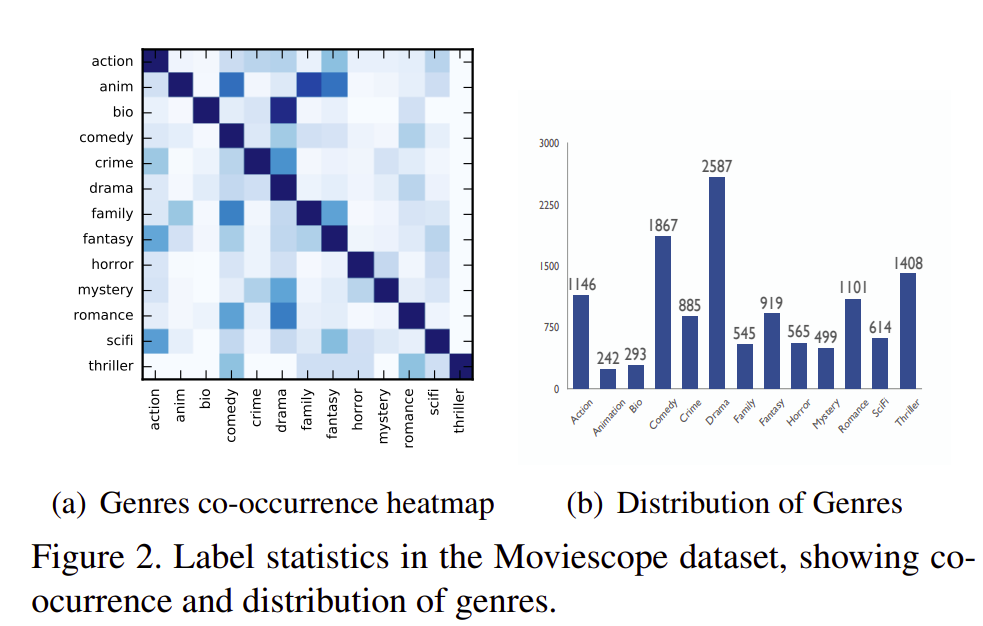

## 2.1 Descarga muestra del 30% 

In [ ]:
!gdown --id 1vHMNsjSre3nZeN5xLAyPg341wEsAlqU7
!gdown --id 1p5LubpGV3a0Ai2OR_Xh_wh1B-8kiQ6bT
!gdown --id 1jKftA1IVyN6VwI-hIA1Dv9TXOWQoYlAr
!gdown --id 12RQGQCtR6GhElyV5-ObpF7FFVWTOBjhF
!gdown --id 1gfZB-Du3hatsaCJ5KhRFWF3ebALgmm1x

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1vHMNsjSre3nZeN5xLAyPg341wEsAlqU7
To: /content/MatchedPostersSample.zip
100% 64.4M/64.4M [00:02<00:00, 30.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1p5LubpGV3a0Ai2OR_Xh_wh1B-8kiQ6bT
To: /content/PostersRandAugmentSample.zip
100% 34.7M/34.7M [00:02<00:00, 12.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWar

In [ ]:
!unzip -qq PostersRandAugmentSample.zip
!unzip -qq MatchedPostersSample.zip

## 2.2 Visualización de los datos

In [ ]:
data_train=[json.loads(l) for l in open("train_sample.jsonl")]
print(len(data_train))

1003


### 2.2.1 Texto

Sinopsis original

In [ ]:
data_train[15]['synopsis']

'Peter Parker plans to propose to Mary Jane Watson, who has just made her Broadway musical debut. A meteorite lands near the two at Central Park, and an extraterrestrial symbiote follows Peter to his apartment. Meanwhile, police pursue escaped prisoner and robber Flint Marko, who goes to see his wife and sick daughter. The chase resumes, and Marko falls into an experimental particle accelerator that fuses his body with the surrounding sand, transforming him into Sandman. Harry Osborn, seeking vengeance for his father\'s death, attacks Peter with newly-made weapons based on his father\'s Green Goblin technology. The fight results in Harry receiving amnesia, erasing his memory of Peter as Spider-Man as well as his vengeance. During a festival honoring Spider-Man, Peter kisses Gwen Stacy for show, infuriating Mary Jane. A newly superpowered Marko robs an armored car and Spider-Man confronts him. Initially warning him to leave to avoid a fight, Marko easily subdues him and escapes. NYPD Ca

Sinopsis aumentadada con Back Translation

In [ ]:
data_train[15]['aug_text']

'Peter Parker plans to propose to Mary Jane Watson, who has just made his Broadway musical debut. A meteorite lands near the two in the center of the park and an extraterrestrial symbote follows Peter to his apartment. Meanwhile, the police continued his prisoner promise and steering wheel, who will see his wife and sick daughter. The continuation of the pursuit and Marko falls into an experimental particle accelerator that merges his body with the surrounding sand, turning it into Sandman. Harry Osborn, looking for revenge for the death of his father, Attack Peter with recently manufactured weapons based on his father\'s Green Geblin technology. The fight ends at Harry receiving Amnesia, erase his memory of Peter as Spider-Man as well as his revenge. During a festival honoring Spider-Man, Peter Kisses Gwen Stacy Stacy Stacy, by infining Mary Jane. A newly superproved Marko point Robus on a shielded car and a spider-man confronts him. Invert it initially to leave to avoid a fight, Mark

### 2.2.2 Imagen

RandAugment

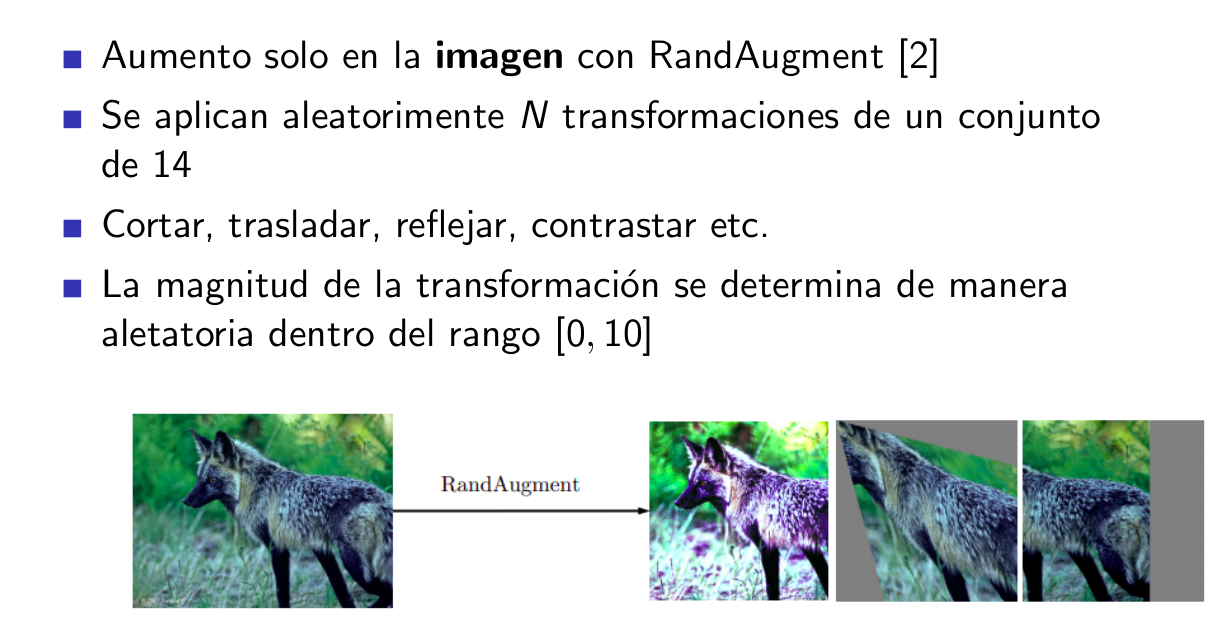

In [ ]:
data_train[15]["id"]

6

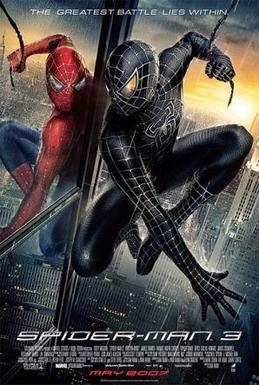

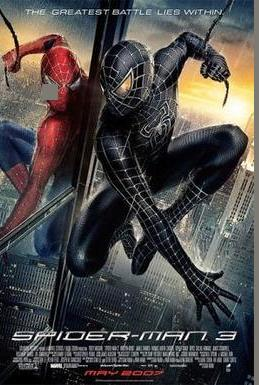

In [ ]:
from IPython.display import display, Image
display(Image(filename='/content/MatchedPostersSample/6.jpg'),Image(filename='/content/PostersRandAugmentSample/6.jpg'))

## 2.3 Procesamiento del dataset

In [ ]:
class JsonlDataset(Dataset):
    def __init__(self, data_path, transforms, args, partition="train"):
        """
          data_path: ruta del archivo .jsonl que contiene el texto y el identificador de la imagen
          transforms: composición de funciones para tranformar la imagen (ej. cambiar tamaño, centrar, normalizar)
          args: hiperparámetros

        """
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.tokenizer = BertTokenizer.from_pretrained(args.bert_model)#función que divide el texto en tokens
        self.args = args
        self.n_classes = len(args.labels)

        self.max_seq_len = args.max_seq_len #512
        if args.model in ["mmbt"]:
            self.max_seq_len -= args.num_image_embeds

        self.transforms = transforms

        self.partition=partition

    def __len__(self):
        return len(self.data)  

    def load_text(self, index, key="synopsis"):
      inputs=self.tokenizer(self.data[index][key], return_tensors="pt", padding='max_length',truncation=True)
      sentence=inputs.input_ids[0]
      segment=inputs.token_type_ids[0]
      attmask=inputs.attention_mask[0]

      if self.args.model == "mmbt":
          # The first SEP is part of Image Token.
          segment = segment[1:]
          sentence = sentence[1:]
          attmask = attmask[1:]
          # The first segment (0) is of images.
          segment += 1

      return sentence, segment, attmask

    def load_image(self, index, folder='MatchedPostersSample'):
      poster = Image.open(
              os.path.join(self.data_dir, folder,
                           f'{str(self.data[index]["id"])}.jpg')
              ).convert("RGB")
      poster = self.transforms(poster)

      return poster


    def __getitem__(self, index):
      sentence, segment, attmask, poster = None, None, None, None
      sentence_aug, segment_aug, attmask_aug, poster_aug = None, None, None, None

      # Load text 
      if self.args.model in ["bert","mmbt"]:
        sentence, segment, attmask= self.load_text(index,"synopsis")

      #Load aug text
      if self.args.uda and self.partition=="train" and self.args.model in ["bert","mmbt"]:
        sentence_aug, segment_aug, attmask_aug= self.load_text(index,"aug_text")


      # Load poster
      if self.args.model in ["mmbt","img"]: 
        poster = self.load_image(index, 'MatchedPostersSample')

      # Load aug poster
      if self.args.uda and self.partition=="train" and self.args.model in ["mmbt","img"]: 
        if self.args.model == "mmbt":
          poster_aug = self.load_image(index, 'MatchedPostersSample') 
        if self.args.model == "img":
          poster_aug = self.load_image(index, 'PostersRandAugmentSample')

      # Process labels
      label = torch.zeros(self.n_classes)
      label[[self.args.labels.index(tgt) for tgt in self.data[index]["label"]]] = 1
            
        
      return sentence, segment, attmask, poster, sentence_aug, segment_aug, attmask_aug, poster_aug, label

In [ ]:
def get_labels_and_frequencies(path):
    label_freqs = Counter()
    data_labels = [json.loads(line)["label"] for line in open(path)]
    if type(data_labels[0]) == list:
        for label_row in data_labels:
            label_freqs.update(label_row)
    else:
        label_freqs.update(data_labels)

    return list(label_freqs.keys()), label_freqs

In [ ]:
def collate_fn(batch, args):
    
    text_tensor, segment_tensor, attmask_tensor,img_tensor, tgt_tensor = None, None, None, None, None
    text_tensor_aug, segment_tensor_aug, attmask_tensor_aug,img_tensor_aug = None, None, None, None

    
    if args.model in ["mmbt", "bert"]:
      text_tensor=torch.stack([row[0] for row in batch])
      segment_tensor=torch.stack([row[1] for row in batch])
      attmask_tensor=torch.stack([row[2] for row in batch])

    if args.model in ["mmbt", "img"]:
        img_tensor = torch.stack([row[3] for row in batch])

    if args.uda and args.model in ["mmbt", "bert"] and batch[0][4] is not None:
      text_tensor_aug=torch.stack([row[4] for row in batch])
      segment_tensor_aug=torch.stack([row[5] for row in batch])
      attmask_tensor_aug=torch.stack([row[6] for row in batch])

    if args.uda and args.model in ["mmbt","img"] and batch[0][7] is not None:
        img_tensor_aug = torch.stack([row[7] for row in batch])

    tgt_tensor = torch.stack([row[8] for row in batch])

    return text_tensor, segment_tensor, attmask_tensor, img_tensor, text_tensor_aug, segment_tensor_aug, attmask_tensor_aug, img_tensor_aug, tgt_tensor

In [ ]:
def get_data_loaders(args):  
  tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=True).tokenize

  #Transformaciones que se aplican a la imagen
  transforms_to_image = transforms.Compose(
        [
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4691, 0.4171, 0.3883], 
                std=[0.3564, 0.3415, 0.3371],
           ),
        ]
    )
  
  args.labels, args.label_freqs = get_labels_and_frequencies(
            os.path.join(args.data_path, args.task, "train_sample.jsonl")
        )
  
  args.n_classes = len(args.labels)
  
  train = JsonlDataset(
            os.path.join(args.data_path, args.task, "train_sample.jsonl"),
            transforms_to_image,
            args,
        )
  
  args.train_data_len = len(train)

  dev = JsonlDataset(
        os.path.join(args.data_path, args.task, "dev_sample.jsonl"),
        transforms_to_image,
        args,
        "dev"
    )
  
  test_set = JsonlDataset(
        os.path.join(args.data_path, args.task, "test_sample.jsonl"),
        transforms_to_image,
        args,
        "test"
    )

  collate = functools.partial(collate_fn, args=args)

  train_loader = DataLoader(
        train,
        batch_size=args.batch_sz,
        shuffle=True,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

  val_loader = DataLoader(
        dev,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )
  test_loader = DataLoader(
        test_set,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

  return train_loader, val_loader, test_loader

# 3. Configuracion del entrenamiento general

In [ ]:
import random
#Para reproducción de resultados
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
def model_forward(i_epoch, model, args, criterion, batch, partition="train"):

    txt, segment, attmask, img, txt_aug, segment_aug, attmask_aug, img_aug, tgt= batch

    avg_unsup_loss=0.0 #unsupervised loss
    
    if args.model =="bert":
        txt, attmask, segment = txt.cuda(), attmask.cuda(), segment.cuda()
        out = model(txt, attmask, segment) #out for supervised loss
        if args.uda and partition=="train":
          txt_aug, attmask_aug, segment_aug = txt_aug.cuda(), attmask_aug.cuda(), segment_aug.cuda()
          q_logits = model(txt_aug, attmask_aug, segment_aug)
          with torch.no_grad(): #No se propaga el gradiente
            p_logits = model(txt, attmask, segment)
          loss_aug = kl_divergence_with_logits(p_logits, q_logits) # Divergencia entre las distribuciones de los datos originales y aumentados
          avg_unsup_loss=torch.sum(loss_aug)
            
    if args.model =="img":
      img = img.cuda()
      out = model(img) #out for supervised loss
      if args.uda and partition=="train":
        img_aug=img_aug.cuda()
        q_logits = model(img_aug)
        with torch.no_grad():
          p_logits = model(img)
        loss_aug = kl_divergence_with_logits(p_logits, q_logits)
        avg_unsup_loss=torch.sum(loss_aug)  

    #Congelamiento de parámetros para el modelo multimodal
    if args.model=='mmbt':
      freeze_img = i_epoch < args.freeze_img
      freeze_txt = i_epoch < args.freeze_txt
      for param in model.enc.img_encoder.parameters():
        param.requires_grad = not freeze_img
      for param in model.enc.encoder.parameters():
        param.requires_grad = not freeze_txt   
    
    if args.model =="mmbt":
      txt, img = txt.cuda(), img.cuda()
      attmask, segment = attmask.cuda(), segment.cuda()
      out = model(txt, attmask, segment, img) #out for supervised loss
      if args.uda and partition=="train":
        txt_aug, attmask_aug, segment_aug = txt_aug.cuda(), attmask_aug.cuda(), segment_aug.cuda()
        img_aug=img_aug.cuda()
        q_logits = model(txt_aug, attmask_aug, segment_aug, img_aug)
        with torch.no_grad():
          p_logits = model(txt, attmask, segment,img)
        loss_aug = kl_divergence_with_logits(p_logits, q_logits)
        avg_unsup_loss=torch.sum(loss_aug)


    tgt = tgt.cuda()
    sup_loss = criterion(out, tgt)
    final_loss=sup_loss+args.unsup_coeff*avg_unsup_loss

    return final_loss, out, tgt

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, average_precision_score

In [ ]:
def model_eval(i_epoch, data, model, args, criterion, store_preds=False):
    with torch.no_grad():
        losses, preds, tgts = [], [], []
        raw_preds= []
        for batch in data:
            loss, out, tgt = model_forward(i_epoch, model, args, criterion, batch, partition="eval")
            losses.append(loss.item())

            pred = torch.sigmoid(out).cpu().detach().numpy() > 0.5
            raw_pred= torch.sigmoid(out).cpu().detach().numpy()
          

            preds.append(pred)
            raw_preds.append(raw_pred)
            tgt = tgt.cpu().detach().numpy()
            tgts.append(tgt)

    metrics = {"loss": np.mean(losses)}
    tgts = np.vstack(tgts)
    preds = np.vstack(preds)
    raw_preds = np.vstack(raw_preds)
    metrics["auc_pr_macro"] = average_precision_score(tgts, raw_preds, average="macro")
    metrics["auc_pr_micro"] = average_precision_score(tgts, raw_preds, average="micro")
        
    return metrics

In [ ]:
def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))

In [ ]:
def train(args,model):
    args.savedir = os.path.join(args.savedir, args.name)
    os.makedirs(args.savedir, exist_ok=True)

    model.cuda()

    torch.save(args, os.path.join(args.savedir, "args.pt"))

    start_epoch, global_step, n_no_improve, best_metric = 0, 0, 0, -np.inf

    #Cargar estado del modelo si ya existía previamente
    if os.path.exists(os.path.join(args.savedir, "checkpoint.pt")):
        checkpoint = torch.load(os.path.join(args.savedir, "checkpoint.pt"))
        start_epoch = checkpoint["epoch"]
        n_no_improve = checkpoint["n_no_improve"]
        best_metric = checkpoint["best_metric"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])

    len_train =len(train_loader)
    for i_epoch in range(start_epoch, args.max_epochs):
        train_losses = []
        model.train()
        optimizer.zero_grad()
        
        for batch in tqdm(train_loader, total=len_train):
            loss, _, _ = model_forward(i_epoch, model, args, criterion, batch)
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            train_losses.append(loss.item())
            loss.backward()
            global_step += 1
            if global_step % args.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        model.eval() #desactiva el dropput
        metrics = model_eval(i_epoch, val_loader, model, args, criterion)
        print("Train Loss: {:.4f}".format(np.mean(train_losses)))
        print("Val:", metrics)

        tuning_metric = (
            metrics["auc_pr_micro"]
        )
        
        scheduler.step(tuning_metric)
        is_improvement = tuning_metric > best_metric
        if is_improvement:
            best_metric = tuning_metric
            n_no_improve = 0
        else:
            n_no_improve += 1

        #Guardar estado actual del modelo
        save_checkpoint(
            {
                "epoch": i_epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "n_no_improve": n_no_improve,
                "best_metric": best_metric,
            },
            is_improvement,
            args.savedir,
        )

        if n_no_improve >= args.patience:
            if args.uda:
              n_no_improve=0
              args.uda=0
              print("Deactivating UDA.")
            else:
              print("No improvement. Breaking out of loop.")
              break

    load_checkpoint(model, os.path.join(args.savedir, "model_best.pt"))
    model.eval()
    test_metrics = model_eval(
        np.inf, test_loader, model, args, criterion, store_preds=True
    )
    print(f"Test:", test_metrics)

In [ ]:
def load_checkpoint(model, path):
    best_checkpoint = torch.load(path)
    model.load_state_dict(best_checkpoint["state_dict"])

# 4. BERT

## 4.1 Clasificador

In [ ]:
class BertClf(nn.Module):
    def __init__(self, args):
        super(BertClf, self).__init__()
        self.args = args
        self.bert = BertModel2.from_pretrained(args.bert_model)
        self.dropout= nn.Dropout(args.dropout)
        self.clf = nn.Linear(args.hidden_sz, args.n_classes)

    def forward(self, txt, mask, segment):
        _, x = self.bert(
            input_ids=txt,
            token_type_ids=segment,
            attention_mask=mask,
            return_dict=False,
        )
        x= self.dropout(x)
        return self.clf(x)

## 4.2 Entrenamiento

### 4.1.1 BERT base

In [ ]:
set_seed(1)
args = argparse.Namespace(
        bert_model="bert-base-uncased",
        model="bert",
        batch_sz=4,
        max_seq_len=512,
        n_workers=2,
        dropout=0.1,
        hidden_sz=768,
        gradient_accumulation_steps=16,
        max_epochs=50,
        patience=5,
        lr=1e-4,
        lr_patience=2,
        lr_factor = 0.5,
        warmup=0.1,
        data_path="",
        task="",
        savedir="",
        name="bert_base_1",
        uda=0,
        unsup_coeff=1

    )

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders(args)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
bert_base = BertClf(args)
#Criterion
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
#optimizer
optimizer = optim.AdamW(bert_base.parameters(), lr=args.lr)
#scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train(args,bert_base)

100%|██████████| 251/251 [01:33<00:00,  2.68it/s]


Train Loss: 0.0780
Val: {'loss': 1.2147406392237718, 'auc_pr_macro': 0.40239965911822406, 'auc_pr_micro': 0.4694104411775249}


100%|██████████| 251/251 [01:35<00:00,  2.62it/s]


Train Loss: 0.0683
Val: {'loss': 0.9358793865231907, 'auc_pr_macro': 0.5654259060135536, 'auc_pr_micro': 0.5275498666706205}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0559
Val: {'loss': 0.8755453167592778, 'auc_pr_macro': 0.5943060883055505, 'auc_pr_micro': 0.5750849443822403}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0459
Val: {'loss': 0.8401996984201319, 'auc_pr_macro': 0.6255888515030321, 'auc_pr_micro': 0.5716536369073326}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0399
Val: {'loss': 0.7579386435887393, 'auc_pr_macro': 0.6730290631371111, 'auc_pr_micro': 0.6549603690281834}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0325
Val: {'loss': 0.7283407519845402, 'auc_pr_macro': 0.695072548584725, 'auc_pr_micro': 0.6862673032600589}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0274
Val: {'loss': 0.7417577566469417, 'auc_pr_macro': 0.6938998714380843, 'auc_pr_micro': 0.6906626747435852}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0234
Val: {'loss': 0.8114422437022714, 'auc_pr_macro': 0.7091235495347112, 'auc_pr_micro': 0.6874764697579985}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0198
Val: {'loss': 0.7912059435073067, 'auc_pr_macro': 0.6989807613976965, 'auc_pr_micro': 0.715590368517421}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0163
Val: {'loss': 0.8135577606804231, 'auc_pr_macro': 0.7008192760236891, 'auc_pr_micro': 0.7140065348632272}


100%|██████████| 251/251 [01:35<00:00,  2.62it/s]


Train Loss: 0.0141
Val: {'loss': 0.8739028038347468, 'auc_pr_macro': 0.6999543866616158, 'auc_pr_micro': 0.7189848447247678}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0122
Val: {'loss': 0.8262004015200278, 'auc_pr_macro': 0.7147379254589542, 'auc_pr_micro': 0.7240867883444839}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0107
Val: {'loss': 0.913419254562434, 'auc_pr_macro': 0.7068502963290513, 'auc_pr_micro': 0.7334862576023943}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0096
Val: {'loss': 0.8833383155219695, 'auc_pr_macro': 0.6938618849731157, 'auc_pr_micro': 0.7212642722929175}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0085
Val: {'loss': 0.9518955626031932, 'auc_pr_macro': 0.708893038652328, 'auc_pr_micro': 0.7301961468267893}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0073
Val: {'loss': 0.9920099132201251, 'auc_pr_macro': 0.7130418306095208, 'auc_pr_micro': 0.7331876335043042}
Epoch 00016: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0064
Val: {'loss': 1.0031274153905756, 'auc_pr_macro': 0.6984945499003731, 'auc_pr_micro': 0.7243563653578717}


100%|██████████| 251/251 [01:36<00:00,  2.61it/s]


Train Loss: 0.0057
Val: {'loss': 1.0016963214558714, 'auc_pr_macro': 0.7033269609196443, 'auc_pr_micro': 0.731440587777825}
No improvement. Breaking out of loop.
Test: {'loss': 0.9246671715298215, 'auc_pr_macro': 0.7105519461019566, 'auc_pr_micro': 0.7276456800101586}


 ## 4.1.2 BERT UDA

In [ ]:
set_seed(1)
args = argparse.Namespace(
        bert_model="bert-base-uncased",
        model="bert",
        batch_sz=4,
        max_seq_len=512,
        n_workers=2,
        dropout=0.1,
        hidden_sz=768,
        gradient_accumulation_steps=16,
        max_epochs=50,
        patience=5,
        lr=1e-4,
        lr_patience=2,
        lr_factor = 0.5,
        warmup=0.1,
        data_path="",
        task="",
        savedir="",
        name="bert_uda_2",
        uda=1,
        unsup_coeff=1

    )

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders(args)
bert_uda = BertClf(args)
#Criterion
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
#optimizer
optimizer = optim.AdamW(bert_uda.parameters(), lr=args.lr)
#scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train(args,bert_uda)

100%|██████████| 251/251 [02:05<00:00,  2.00it/s]


Train Loss: 0.0805
Val: {'loss': 1.196508700356764, 'auc_pr_macro': 0.39555134432504274, 'auc_pr_micro': 0.48653047169389174}


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0737
Val: {'loss': 1.0476994233972885, 'auc_pr_macro': 0.5251422734305936, 'auc_pr_micro': 0.4960194685669479}


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0671
Val: {'loss': 1.0451452223693622, 'auc_pr_macro': 0.5336056221852669, 'auc_pr_micro': 0.4194379426003867}


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0602
Val: {'loss': 0.8709409841719795, 'auc_pr_macro': 0.6085375371467469, 'auc_pr_micro': 0.5257163991857489}


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0560
Val: {'loss': 0.8730224151821697, 'auc_pr_macro': 0.5958036856368625, 'auc_pr_micro': 0.5237284430112854}


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0518
Val: {'loss': 0.8041040047126657, 'auc_pr_macro': 0.6325704133971978, 'auc_pr_micro': 0.6169688201615037}


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0477
Val: {'loss': 0.8088584480916753, 'auc_pr_macro': 0.637999813877265, 'auc_pr_micro': 0.5838001259794576}


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0464
Val: {'loss': 0.8046541555839426, 'auc_pr_macro': 0.6407368859873933, 'auc_pr_micro': 0.6108344435925137}


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0446
Val: {'loss': 0.9511462397435132, 'auc_pr_macro': 0.615473363345671, 'auc_pr_micro': 0.550741865426779}
Epoch 00009: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0419
Val: {'loss': 0.8463024821351556, 'auc_pr_macro': 0.6479968484628839, 'auc_pr_micro': 0.6122054194319946}


100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


Train Loss: 0.0395
Val: {'loss': 0.8434082602753359, 'auc_pr_macro': 0.6503690586444849, 'auc_pr_micro': 0.6020922675107307}
Deactivating UDA.


100%|██████████| 251/251 [00:54<00:00,  4.64it/s]


Train Loss: 0.0314
Val: {'loss': 0.8199251162655213, 'auc_pr_macro': 0.6811711117267709, 'auc_pr_micro': 0.6252768172748288}


100%|██████████| 251/251 [00:54<00:00,  4.65it/s]


Train Loss: 0.0289
Val: {'loss': 0.8313883271287469, 'auc_pr_macro': 0.6790222919554468, 'auc_pr_micro': 0.6642470385339327}


100%|██████████| 251/251 [00:54<00:00,  4.65it/s]


Train Loss: 0.0270
Val: {'loss': 0.8301303500638288, 'auc_pr_macro': 0.6828263691378667, 'auc_pr_micro': 0.6772006490913398}


100%|██████████| 251/251 [00:54<00:00,  4.64it/s]


Train Loss: 0.0253
Val: {'loss': 0.837074801325798, 'auc_pr_macro': 0.6848675371792976, 'auc_pr_micro': 0.6755599522599871}


100%|██████████| 251/251 [00:54<00:00,  4.64it/s]


Train Loss: 0.0238
Val: {'loss': 0.8447814864270827, 'auc_pr_macro': 0.6968701925562694, 'auc_pr_micro': 0.6872175506819842}


100%|██████████| 251/251 [00:53<00:00,  4.65it/s]


Train Loss: 0.0223
Val: {'loss': 0.859545590246425, 'auc_pr_macro': 0.6810531204867724, 'auc_pr_micro': 0.6915239223254995}


100%|██████████| 251/251 [00:54<00:00,  4.64it/s]


Train Loss: 0.0210
Val: {'loss': 0.8762503520530813, 'auc_pr_macro': 0.6852954281376687, 'auc_pr_micro': 0.7001442292800907}


100%|██████████| 251/251 [00:54<00:00,  4.64it/s]


Train Loss: 0.0197
Val: {'loss': 0.9095069319009781, 'auc_pr_macro': 0.6844462614342887, 'auc_pr_micro': 0.6966969376610624}


100%|██████████| 251/251 [00:54<00:00,  4.65it/s]


Train Loss: 0.0184
Val: {'loss': 0.9082449648310157, 'auc_pr_macro': 0.6835703523423022, 'auc_pr_micro': 0.70239602236148}


100%|██████████| 251/251 [00:54<00:00,  4.65it/s]


Train Loss: 0.0171
Val: {'loss': 0.9294503006864997, 'auc_pr_macro': 0.680279645704592, 'auc_pr_micro': 0.7066513379123178}


100%|██████████| 251/251 [00:54<00:00,  4.64it/s]


Train Loss: 0.0160
Val: {'loss': 0.9385391912039589, 'auc_pr_macro': 0.6824450886481483, 'auc_pr_micro': 0.7030160372630877}


100%|██████████| 251/251 [00:54<00:00,  4.64it/s]


Train Loss: 0.0148
Val: {'loss': 0.9425855371005395, 'auc_pr_macro': 0.6831620064011147, 'auc_pr_micro': 0.6945035643648256}


100%|██████████| 251/251 [00:54<00:00,  4.64it/s]


Train Loss: 0.0138
Val: {'loss': 0.9563971814863822, 'auc_pr_macro': 0.6767527822478451, 'auc_pr_micro': 0.6978449727776567}
Epoch 00024: reducing learning rate of group 0 to 2.5000e-05.


100%|██████████| 251/251 [00:54<00:00,  4.65it/s]


Train Loss: 0.0129
Val: {'loss': 0.9937961162889705, 'auc_pr_macro': 0.6773377290575754, 'auc_pr_micro': 0.704644647434214}


100%|██████████| 251/251 [00:54<00:00,  4.64it/s]


Train Loss: 0.0123
Val: {'loss': 0.9942427404663142, 'auc_pr_macro': 0.6780525673594954, 'auc_pr_micro': 0.7013146584513388}
No improvement. Breaking out of loop.
Test: {'loss': 0.8428698294871563, 'auc_pr_macro': 0.7066404905990927, 'auc_pr_micro': 0.730348042275064}


# 5. Resnet 152

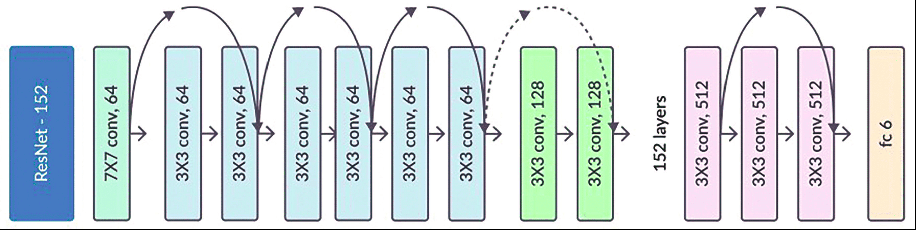

## 5.1 Image encoder

In [ ]:
import torch
import torch.nn as nn
import torchvision


class ImageEncoder(nn.Module):
    def __init__(self, args):
        super(ImageEncoder, self).__init__()
        self.args = args
        model = torchvision.models.resnet152(pretrained=True)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)

        pool_func = (
            nn.AdaptiveAvgPool2d
            if args.img_embed_pool_type == "avg"
            else nn.AdaptiveMaxPool2d
        )

        if args.num_image_embeds in [1, 2, 3, 5, 7]:
            self.pool = pool_func((args.num_image_embeds, 1))
        elif args.num_image_embeds == 4:
            self.pool = pool_func((2, 2))
        elif args.num_image_embeds == 6:
            self.pool = pool_func((3, 2))
        elif args.num_image_embeds == 8:
            self.pool = pool_func((4, 2))
        elif args.num_image_embeds == 9:
            self.pool = pool_func((3, 3))

    def forward(self, x):
        # Bx3x224x224 -> Bx2048x7x7 -> Bx2048xN -> BxNx2048
        y=self.model(x)
        out = self.pool(y)
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        return out  # BxNx2048

## 5.2 Image classificator

In [ ]:
class ImageClf(nn.Module):
    def __init__(self, args):
        super(ImageClf, self).__init__()
        self.args = args
        self.img_encoder = ImageEncoder(args)
        self.clf = nn.Linear(args.img_hidden_sz * args.num_image_embeds, args.n_classes)

    def forward(self, x):
        x = self.img_encoder(x)
        x = torch.flatten(x, start_dim=1)
        out = self.clf(x)
        return out

## 5.3 Entrenamiento

### 5.3.1 ResNet 152 base

In [ ]:
set_seed(1)
args = argparse.Namespace(
        bert_model="bert-base-uncased",
        model="img",
        num_image_embeds=1,
        img_embed_pool_type="avg",
        img_hidden_sz=2048,
        batch_sz=4,
        max_seq_len=512,
        n_classes=13,
        n_workers=2,
        dropout=0.1,
        hidden_sz=768,
        gradient_accumulation_steps=16,
        max_epochs=50,
        patience=5,
        lr=1e-4,
        lr_patience=2,
        lr_factor = 0.5,
        warmup=0.1,
        data_path="",
        task="",
        savedir="",
        name="image_base_1",
        uda=0,
        unsup_coeff=1

    )

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders(args)
image_base=ImageClf(args)
#Criterion
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
#optimizer
optimizer = optim.AdamW(image_base.parameters(), lr=args.lr)
#scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
train(args,image_base)

100%|██████████| 251/251 [00:47<00:00,  5.29it/s]


Train Loss: 0.0741
Val: {'loss': 1.1096228711745317, 'auc_pr_macro': 0.3980492956984566, 'auc_pr_micro': 0.46622390052099905}


100%|██████████| 251/251 [00:47<00:00,  5.24it/s]


Train Loss: 0.0628
Val: {'loss': 1.0564379201215857, 'auc_pr_macro': 0.4414426898589712, 'auc_pr_micro': 0.49496651616098836}


100%|██████████| 251/251 [00:48<00:00,  5.15it/s]


Train Loss: 0.0521
Val: {'loss': 1.0856919016908197, 'auc_pr_macro': 0.4576625704961111, 'auc_pr_micro': 0.5011338058971199}


100%|██████████| 251/251 [00:48<00:00,  5.14it/s]


Train Loss: 0.0439
Val: {'loss': 1.1586891000761705, 'auc_pr_macro': 0.4616980514120869, 'auc_pr_micro': 0.5248654754132352}


100%|██████████| 251/251 [00:48<00:00,  5.13it/s]


Train Loss: 0.0378
Val: {'loss': 1.2464843295952852, 'auc_pr_macro': 0.4713800968677629, 'auc_pr_micro': 0.5150531903084432}


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0334
Val: {'loss': 1.3298099154935163, 'auc_pr_macro': 0.4477196531351061, 'auc_pr_micro': 0.5336956223070172}


100%|██████████| 251/251 [00:48<00:00,  5.13it/s]


Train Loss: 0.0294
Val: {'loss': 1.452321674893884, 'auc_pr_macro': 0.4335910326390404, 'auc_pr_micro': 0.4787396553696118}


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0264
Val: {'loss': 1.4535962728893055, 'auc_pr_macro': 0.4253396172886862, 'auc_pr_micro': 0.5034399322883429}


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0254
Val: {'loss': 1.496496425832019, 'auc_pr_macro': 0.4418802223537527, 'auc_pr_micro': 0.5011624917362456}
Epoch 00009: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 251/251 [00:48<00:00,  5.13it/s]


Train Loss: 0.0218
Val: {'loss': 1.4600609102669884, 'auc_pr_macro': 0.4477132519133547, 'auc_pr_micro': 0.49565713720102617}


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0203
Val: {'loss': 1.6093945985331255, 'auc_pr_macro': 0.43993124684793944, 'auc_pr_micro': 0.5224988368900392}
No improvement. Breaking out of loop.
Test: {'loss': 1.3183797851607606, 'auc_pr_macro': 0.43426417474913087, 'auc_pr_micro': 0.5102577564531362}


### 5.3.2 ResNet 152 uda

In [ ]:
set_seed(1)
args = argparse.Namespace(
        bert_model="bert-base-uncased",
        model="img",
        num_image_embeds=1,
        img_embed_pool_type="avg",
        img_hidden_sz=2048,
        batch_sz=4,
        max_seq_len=512,
        n_classes=13,
        n_workers=2,
        dropout=0.1,
        hidden_sz=768,
        gradient_accumulation_steps=16,
        max_epochs=50,
        patience=5,
        lr=1e-4,
        lr_patience=2,
        lr_factor = 0.5,
        warmup=0.1,
        data_path="",
        task="",
        savedir="",
        name="image_uda_1",
        uda=1,
        unsup_coeff=1

    )

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders(args)
image_uda=ImageClf(args)
#Criterion
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
#optimizer
optimizer = optim.AdamW(image_uda.parameters(), lr=args.lr)
#scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

In [ ]:
train(args,image_uda)

100%|██████████| 251/251 [01:48<00:00,  2.31it/s]


Train Loss: 0.0765
Val: {'loss': 1.156257557518342, 'auc_pr_macro': 0.3686878877171461, 'auc_pr_micro': 0.43119646707365816}


100%|██████████| 251/251 [01:49<00:00,  2.30it/s]


Train Loss: 0.0682
Val: {'loss': 1.0878366056610556, 'auc_pr_macro': 0.41352636212768246, 'auc_pr_micro': 0.449521481444949}


100%|██████████| 251/251 [01:49<00:00,  2.29it/s]


Train Loss: 0.0620
Val: {'loss': 1.0626817889073317, 'auc_pr_macro': 0.43293841521707976, 'auc_pr_micro': 0.44654281959278586}


100%|██████████| 251/251 [01:49<00:00,  2.30it/s]


Train Loss: 0.0590
Val: {'loss': 1.0988757697974934, 'auc_pr_macro': 0.4348709820088597, 'auc_pr_micro': 0.4503510774028018}


100%|██████████| 251/251 [01:49<00:00,  2.30it/s]


Train Loss: 0.0561
Val: {'loss': 1.1618620192303377, 'auc_pr_macro': 0.43599932662729124, 'auc_pr_micro': 0.46446927054175513}


100%|██████████| 251/251 [01:49<00:00,  2.30it/s]


Train Loss: 0.0547
Val: {'loss': 1.2161454724914886, 'auc_pr_macro': 0.41296819752594194, 'auc_pr_micro': 0.43924833125431373}


100%|██████████| 251/251 [01:48<00:00,  2.31it/s]


Train Loss: 0.0508
Val: {'loss': 1.4142949905465632, 'auc_pr_macro': 0.4069604629750715, 'auc_pr_micro': 0.3978618106158858}


100%|██████████| 251/251 [01:48<00:00,  2.30it/s]


Train Loss: 0.0489
Val: {'loss': 1.2637496275060318, 'auc_pr_macro': 0.4315362028055377, 'auc_pr_micro': 0.4158975703599786}
Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 251/251 [01:48<00:00,  2.30it/s]


Train Loss: 0.0469
Val: {'loss': 1.2379119133248049, 'auc_pr_macro': 0.43050503323075656, 'auc_pr_micro': 0.4543133002393117}


100%|██████████| 251/251 [01:48<00:00,  2.31it/s]


Train Loss: 0.0424
Val: {'loss': 1.3261055210057426, 'auc_pr_macro': 0.4176192761264787, 'auc_pr_micro': 0.4475340005261348}
Deactivating UDA.


100%|██████████| 251/251 [00:49<00:00,  5.12it/s]


Train Loss: 0.0346
Val: {'loss': 1.4347410070545532, 'auc_pr_macro': 0.40858400150356383, 'auc_pr_micro': 0.464657595243543}


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0319
Val: {'loss': 1.4453255805899115, 'auc_pr_macro': 0.43923435355221974, 'auc_pr_micro': 0.4984281194604784}


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0301
Val: {'loss': 1.4039682956302868, 'auc_pr_macro': 0.4392407882434484, 'auc_pr_micro': 0.503063232078769}


100%|██████████| 251/251 [00:49<00:00,  5.10it/s]


Train Loss: 0.0286
Val: {'loss': 1.384419957504553, 'auc_pr_macro': 0.4323820029339276, 'auc_pr_micro': 0.508206034975209}


100%|██████████| 251/251 [00:49<00:00,  5.10it/s]


Train Loss: 0.0275
Val: {'loss': 1.445275373318616, 'auc_pr_macro': 0.4375216921453243, 'auc_pr_micro': 0.5157198550985868}


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0254
Val: {'loss': 1.5116538379122229, 'auc_pr_macro': 0.43030539859318634, 'auc_pr_micro': 0.514407801238057}


100%|██████████| 251/251 [00:48<00:00,  5.13it/s]


Train Loss: 0.0242
Val: {'loss': 1.573162374251029, 'auc_pr_macro': 0.43881279147924085, 'auc_pr_micro': 0.5290227166095373}


100%|██████████| 251/251 [00:49<00:00,  5.10it/s]


Train Loss: 0.0234
Val: {'loss': 1.5301456293639015, 'auc_pr_macro': 0.4460770771430728, 'auc_pr_micro': 0.5263922069441963}


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0228
Val: {'loss': 1.5787975069354563, 'auc_pr_macro': 0.43000858169165745, 'auc_pr_micro': 0.5095826877427465}


100%|██████████| 251/251 [00:49<00:00,  5.12it/s]


Train Loss: 0.0211
Val: {'loss': 1.5240531458574182, 'auc_pr_macro': 0.4243000328271155, 'auc_pr_micro': 0.5100344562829091}
Epoch 00020: reducing learning rate of group 0 to 2.5000e-05.


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0206
Val: {'loss': 1.4978990598636515, 'auc_pr_macro': 0.4354925542151783, 'auc_pr_micro': 0.5207110664522685}


100%|██████████| 251/251 [00:49<00:00,  5.11it/s]


Train Loss: 0.0197
Val: {'loss': 1.5090342207866556, 'auc_pr_macro': 0.4377166288637674, 'auc_pr_micro': 0.5107680436757727}
No improvement. Breaking out of loop.
Test: {'loss': 1.523402811707677, 'auc_pr_macro': 0.4483826735811128, 'auc_pr_micro': 0.5337968950133558}


# 6. Multimodal Bitransformers for Classifying Images and Text (MMBT)




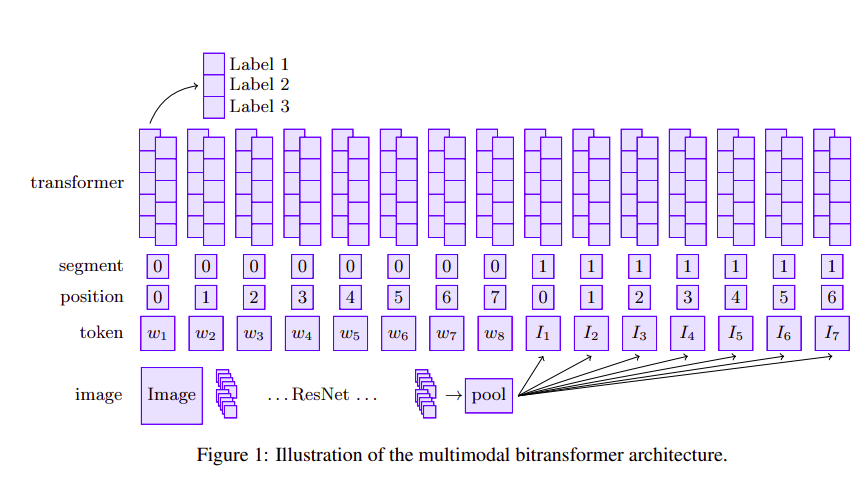

## 6.1 ImageBertEmbeddings

In [ ]:
class ImageBertEmbeddings(nn.Module):
    def __init__(self, args, embeddings):
        super(ImageBertEmbeddings, self).__init__()
        self.args = args
        self.img_embeddings = nn.Linear(args.img_hidden_sz, args.hidden_sz)
        self.position_embeddings = embeddings.position_embeddings
        self.token_type_embeddings = embeddings.token_type_embeddings
        self.word_embeddings = embeddings.word_embeddings
        self.LayerNorm = embeddings.LayerNorm
        self.dropout = nn.Dropout(p=args.dropout)

    def forward(self, input_imgs, token_type_ids):
        bsz = input_imgs.size(0)
        seq_length = self.args.num_image_embeds + 2  # +2 for CLS and SEP Token

        cls_id = torch.LongTensor([101]).cuda() #[CLS]=101
        cls_id = cls_id.unsqueeze(0).expand(bsz, 1)
        cls_token_embeds = self.word_embeddings(cls_id)

        sep_id = torch.LongTensor([102]).cuda() #[SEP]=102
        sep_id = sep_id.unsqueeze(0).expand(bsz, 1)
        sep_token_embeds = self.word_embeddings(sep_id)

        imgs_embeddings = self.img_embeddings(input_imgs) #Transfirma a la dimensión de los embeddings de texto
        token_embeddings = torch.cat(
            [cls_token_embeds, imgs_embeddings, sep_token_embeds], dim=1
        )

        position_ids = torch.arange(seq_length, dtype=torch.long).cuda()
        position_ids = position_ids.unsqueeze(0).expand(bsz, seq_length)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        embeddings = token_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

## 6.2 Multimodal Encoder

In [ ]:
from pytorch_pretrained_bert.modeling import BertModel

In [ ]:
class MultimodalBertEncoder(nn.Module):
    def __init__(self, args):
        super(MultimodalBertEncoder, self).__init__()
        self.args = args
        bert = BertModel.from_pretrained(args.bert_model)
        self.txt_embeddings = bert.embeddings

        self.img_embeddings = ImageBertEmbeddings(args, self.txt_embeddings)
        self.img_encoder = ImageEncoder(args)
        self.encoder = bert.encoder
        self.pooler = bert.pooler # toma el token cls de la última capa del encoder
        self.clf = nn.Linear(args.hidden_sz, args.n_classes)

    def forward(self, input_txt, attention_mask, segment, input_img):
        bsz = input_txt.size(0)

        #Extender la máscara de atención a la imagen
        attention_mask = torch.cat(
            [
                torch.ones(bsz, self.args.num_image_embeds + 2).long().cuda(),
                attention_mask,
            ],
            dim=1,
        )
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(
            dtype=next(self.parameters()).dtype
        )
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        img_tok = (
            torch.LongTensor(input_txt.size(0), self.args.num_image_embeds + 2)
            .fill_(0)
            .cuda()
        )
        img = self.img_encoder(input_img)  # BxNx3x224x224 -> BxNx2048  
        img_embed_out = self.img_embeddings(img, img_tok)
        txt_embed_out = self.txt_embeddings(input_txt, segment)
        encoder_input = torch.cat([img_embed_out, txt_embed_out], 1)  # Bx(IMG+TEXT)xHID
        
        encoded_layers = self.encoder(
            encoder_input, extended_attention_mask, output_all_encoded_layers=False
        )

        return self.pooler(encoded_layers[-1])

## 6.3 Multimodal Bitransformer Classificator

In [ ]:
class MultimodalBertClf(nn.Module):
    def __init__(self, args):
        super(MultimodalBertClf, self).__init__()
        self.args = args
        self.enc = MultimodalBertEncoder(args)
        self.clf = nn.Linear(args.hidden_sz, args.n_classes)

    def forward(self, txt, mask, segment, img):
        x = self.enc(txt, mask, segment, img)
        return self.clf(x)

## 6.4 Entrenamiento

### 6.4.1 mmbt base

In [ ]:
args = argparse.Namespace(
        bert_model="bert-base-uncased",
        model="mmbt",
        batch_sz=8,
        task_type="multilabel",
        max_seq_len=512,
        num_image_embeds=3,
        n_workers=2,
        dropout=0.1,
        hidden_sz=768,
        gradient_accumulation_steps=32,
        max_epochs=50,
        lr=1e-4,
        patience=5,
        lr_patience=2,
        warmup=0.1,
        freeze_img=2,
        freeze_txt=5,
        img_hidden_sz=2048,
        data_path="",
        task="",
        img_embed_pool_type="avg",
        n_classes=13,
        savedir="",
        name="mmbt_base",
        uda=0,
        unsup_coeff=1
    )

In [ ]:
train_loader, val_loader, test_loader =get_data_loaders(args)
mmbt_base=MultimodalBertClf(args)
#Criterion
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
#optimizer
optimizer = optim.AdamW(mmbt_base.parameters(), lr=args.lr)
#scheduler
args.lr_factor = 0.5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

100%|██████████| 407873900/407873900 [00:36<00:00, 11328559.91B/s]


In [ ]:
train(args,mmbt_base)

100%|██████████| 126/126 [01:36<00:00,  1.30it/s]


Train Loss: 0.0397
Val: {'loss': 1.2567594121484196, 'auc_pr_macro': 0.24532051532632143, 'auc_pr_micro': 0.2272126602623178}


100%|██████████| 126/126 [01:38<00:00,  1.28it/s]


Train Loss: 0.0384
Val: {'loss': 1.218537621638354, 'auc_pr_macro': 0.2697930709389128, 'auc_pr_micro': 0.31181207328268423}


100%|██████████| 126/126 [02:08<00:00,  1.02s/it]


Train Loss: 0.0377
Val: {'loss': 1.201830011956832, 'auc_pr_macro': 0.3019687200017882, 'auc_pr_micro': 0.3820483206047568}


100%|██████████| 126/126 [02:08<00:00,  1.02s/it]


Train Loss: 0.0372
Val: {'loss': 1.1885593568577486, 'auc_pr_macro': 0.34960820563940886, 'auc_pr_micro': 0.4263378135614126}


100%|██████████| 126/126 [02:08<00:00,  1.02s/it]


Train Loss: 0.0366
Val: {'loss': 1.177628334830789, 'auc_pr_macro': 0.38109037073122237, 'auc_pr_micro': 0.45062317390005047}


100%|██████████| 126/126 [02:30<00:00,  1.20s/it]


Train Loss: 0.0367
Val: {'loss': 1.1678296152283163, 'auc_pr_macro': 0.5345763407235489, 'auc_pr_micro': 0.28602866903084634}


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0329
Val: {'loss': 1.0026639489566578, 'auc_pr_macro': 0.6096716065637195, 'auc_pr_micro': 0.557570510521139}


100%|██████████| 126/126 [02:30<00:00,  1.20s/it]


Train Loss: 0.0296
Val: {'loss': 0.9135399916592766, 'auc_pr_macro': 0.6232839918871946, 'auc_pr_micro': 0.6344628331647443}


100%|██████████| 126/126 [02:30<00:00,  1.20s/it]


Train Loss: 0.0266
Val: {'loss': 0.8508357826401206, 'auc_pr_macro': 0.650096875061728, 'auc_pr_micro': 0.6282917202492239}


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0240
Val: {'loss': 0.7940888510030859, 'auc_pr_macro': 0.677635204684515, 'auc_pr_micro': 0.6662381152563822}


100%|██████████| 126/126 [02:30<00:00,  1.20s/it]


Train Loss: 0.0219
Val: {'loss': 0.7820672743460712, 'auc_pr_macro': 0.6990598053221155, 'auc_pr_micro': 0.647928311262006}


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0201
Val: {'loss': 0.7354806153213277, 'auc_pr_macro': 0.6941749032003961, 'auc_pr_micro': 0.709869658486337}


100%|██████████| 126/126 [02:30<00:00,  1.20s/it]


Train Loss: 0.0182
Val: {'loss': 0.73555928644012, 'auc_pr_macro': 0.6957397143132268, 'auc_pr_micro': 0.6935086254633375}


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0166
Val: {'loss': 0.7436479207347421, 'auc_pr_macro': 0.704606168459776, 'auc_pr_micro': 0.7152651773758671}


100%|██████████| 126/126 [02:30<00:00,  1.20s/it]


Train Loss: 0.0150
Val: {'loss': 0.7434666875530692, 'auc_pr_macro': 0.7063759601218496, 'auc_pr_micro': 0.7287226047960675}


100%|██████████| 126/126 [02:30<00:00,  1.20s/it]


Train Loss: 0.0138
Val: {'loss': 0.7707288475597606, 'auc_pr_macro': 0.7168760835008485, 'auc_pr_micro': 0.7201982982789918}


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0127
Val: {'loss': 0.734557718038559, 'auc_pr_macro': 0.7177724425891092, 'auc_pr_micro': 0.7381907967376019}


100%|██████████| 126/126 [02:30<00:00,  1.19s/it]


Train Loss: 0.0117
Val: {'loss': 0.7614163458347321, 'auc_pr_macro': 0.7215646032707738, 'auc_pr_micro': 0.7396953940647096}


100%|██████████| 126/126 [02:30<00:00,  1.19s/it]


Train Loss: 0.0109
Val: {'loss': 0.7622669794980217, 'auc_pr_macro': 0.7272938661499396, 'auc_pr_micro': 0.7375028958558792}


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0102
Val: {'loss': 0.775180401170955, 'auc_pr_macro': 0.7237458457774362, 'auc_pr_micro': 0.7446850649005791}


100%|██████████| 126/126 [02:30<00:00,  1.19s/it]


Train Loss: 0.0096
Val: {'loss': 0.7651814906036153, 'auc_pr_macro': 0.7181679958577291, 'auc_pr_micro': 0.7366521992075342}


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0090
Val: {'loss': 0.8260888580013724, 'auc_pr_macro': 0.7218577017204875, 'auc_pr_micro': 0.7438948239710708}


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0087
Val: {'loss': 0.7837726228377399, 'auc_pr_macro': 0.7251352940797494, 'auc_pr_micro': 0.7291546753533539}
Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0082
Val: {'loss': 0.8219493347055772, 'auc_pr_macro': 0.7124454994959672, 'auc_pr_micro': 0.7350446227483547}


100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Train Loss: 0.0081
Val: {'loss': 0.8439411205403945, 'auc_pr_macro': 0.7207012224199183, 'auc_pr_micro': 0.7248192989387019}
No improvement. Breaking out of loop.
Test: {'loss': 0.7757435006064337, 'auc_pr_macro': 0.715845112772927, 'auc_pr_micro': 0.7418656357625681}


### 6.4.2 mmbt uda

In [ ]:
args = argparse.Namespace(
        bert_model="bert-base-uncased",
        model="mmbt",
        batch_sz=4,
        task_type="multilabel",
        max_seq_len=512,
        num_image_embeds=3,
        n_workers=2,
        dropout=0.1,
        hidden_sz=768,
        gradient_accumulation_steps=32,
        max_epochs=50,
        lr=1e-4,
        patience=5,
        lr_patience=2,
        warmup=0.1,
        freeze_img=2,
        freeze_txt=5,
        img_hidden_sz=2048,
        data_path="",
        task="",
        img_embed_pool_type="avg",
        n_classes=13,
        savedir="",
        name="mmbt_uda_text_05_1",
        uda=1,
        unsup_coeff=0.5,

    )

In [ ]:
train_loader, val_loader, test_loader =get_data_loaders(args)
mmbt_uda_text=MultimodalBertClf(args)
#Criterion
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
#optimizer
optimizer = optim.AdamW(mmbt_uda_text.parameters(), lr=args.lr)
#scheduler
args.lr_factor = 0.5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 407873900/407873900 [00:15<00:00, 26550993.13B/s]
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
train(args,mmbt_uda_text)

100%|██████████| 251/251 [04:26<00:00,  1.06s/it]


Train Loss: 0.0412
Val: {'loss': 1.244595436488881, 'auc_pr_macro': 0.24106740365986437, 'auc_pr_micro': 0.3309861200739195}


100%|██████████| 251/251 [04:40<00:00,  1.12s/it]


Train Loss: 0.0386
Val: {'loss': 1.2211055334876566, 'auc_pr_macro': 0.33167548314109996, 'auc_pr_micro': 0.44978226136142385}


100%|██████████| 251/251 [05:34<00:00,  1.33s/it]


Train Loss: 0.0377
Val: {'loss': 1.20139921763364, 'auc_pr_macro': 0.41089989435154267, 'auc_pr_micro': 0.4756145068374191}


100%|██████████| 251/251 [05:34<00:00,  1.33s/it]


Train Loss: 0.0370
Val: {'loss': 1.1815330473815693, 'auc_pr_macro': 0.4314975844564851, 'auc_pr_micro': 0.45317423993330525}


100%|██████████| 251/251 [05:34<00:00,  1.33s/it]


Train Loss: 0.0361
Val: {'loss': 1.1587145030498505, 'auc_pr_macro': 0.4557986073103434, 'auc_pr_micro': 0.39505826409766936}


100%|██████████| 251/251 [06:22<00:00,  1.52s/it]


Train Loss: 0.0336
Val: {'loss': 0.9708093369708342, 'auc_pr_macro': 0.586593611887282, 'auc_pr_micro': 0.5422879816025337}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0275
Val: {'loss': 0.8551870777326471, 'auc_pr_macro': 0.6393896443803921, 'auc_pr_micro': 0.6041549230054243}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0247
Val: {'loss': 0.7620241037186455, 'auc_pr_macro': 0.6857488379382357, 'auc_pr_micro': 0.6495220823452783}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0222
Val: {'loss': 0.7379303776166019, 'auc_pr_macro': 0.6929534579487151, 'auc_pr_micro': 0.6574221636278338}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0201
Val: {'loss': 0.7360832480823293, 'auc_pr_macro': 0.6991045881738949, 'auc_pr_micro': 0.6355333828265395}


100%|██████████| 251/251 [06:22<00:00,  1.52s/it]


Train Loss: 0.0190
Val: {'loss': 0.7535761910326341, 'auc_pr_macro': 0.683863408995189, 'auc_pr_micro': 0.6410921550665386}


100%|██████████| 251/251 [06:22<00:00,  1.53s/it]


Train Loss: 0.0172
Val: {'loss': 0.7603866203742868, 'auc_pr_macro': 0.6919046264455844, 'auc_pr_micro': 0.7086042689830316}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0157
Val: {'loss': 0.7951982792686013, 'auc_pr_macro': 0.7047201342489612, 'auc_pr_micro': 0.7230813150957474}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0156
Val: {'loss': 0.8288968056440353, 'auc_pr_macro': 0.6947080909811519, 'auc_pr_micro': 0.7048295563177079}


100%|██████████| 251/251 [06:22<00:00,  1.53s/it]


Train Loss: 0.0146
Val: {'loss': 0.8234759437687257, 'auc_pr_macro': 0.7144908817778342, 'auc_pr_micro': 0.6825716457067019}


100%|██████████| 251/251 [06:22<00:00,  1.53s/it]


Train Loss: 0.0140
Val: {'loss': 0.8139890178161509, 'auc_pr_macro': 0.7162287033435069, 'auc_pr_micro': 0.7120554168281209}
Epoch 00016: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 251/251 [06:22<00:00,  1.53s/it]


Train Loss: 0.0127
Val: {'loss': 0.7385488731019637, 'auc_pr_macro': 0.7170577940116983, 'auc_pr_micro': 0.7280246039584584}


100%|██████████| 251/251 [06:25<00:00,  1.53s/it]


Train Loss: 0.0121
Val: {'loss': 0.7712636984446469, 'auc_pr_macro': 0.719332336423088, 'auc_pr_micro': 0.730202168409867}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0114
Val: {'loss': 0.7826328632586143, 'auc_pr_macro': 0.7410651386717727, 'auc_pr_micro': 0.7326809158918991}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0108
Val: {'loss': 0.741959315012483, 'auc_pr_macro': 0.743498776592785, 'auc_pr_micro': 0.7579898735957379}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0106
Val: {'loss': 0.7981381758170969, 'auc_pr_macro': 0.7392527070469581, 'auc_pr_micro': 0.750112831318591}


100%|██████████| 251/251 [06:22<00:00,  1.53s/it]


Train Loss: 0.0104
Val: {'loss': 0.7842885970192797, 'auc_pr_macro': 0.7531254074220161, 'auc_pr_micro': 0.7641781918451732}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0100
Val: {'loss': 0.7759786217528231, 'auc_pr_macro': 0.7303891725239465, 'auc_pr_micro': 0.7515449284995506}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0095
Val: {'loss': 0.7824157077599975, 'auc_pr_macro': 0.7311018783072465, 'auc_pr_micro': 0.7618228277923147}


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0093
Val: {'loss': 0.8375067377791685, 'auc_pr_macro': 0.7186063945640826, 'auc_pr_micro': 0.7563415609696057}
Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.


100%|██████████| 251/251 [06:23<00:00,  1.53s/it]


Train Loss: 0.0087
Val: {'loss': 0.7913644226158366, 'auc_pr_macro': 0.73173809722329, 'auc_pr_micro': 0.7586568666610151}


100%|██████████| 251/251 [06:24<00:00,  1.53s/it]


Train Loss: 0.0088
Val: {'loss': 0.8572360255262431, 'auc_pr_macro': 0.7330445175899852, 'auc_pr_micro': 0.748730003181286}
Deactivating UDA.


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0071
Val: {'loss': 0.8261182886712691, 'auc_pr_macro': 0.733767852570917, 'auc_pr_micro': 0.763061501164855}
Epoch 00028: reducing learning rate of group 0 to 1.2500e-05.


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0067
Val: {'loss': 0.8193064511698835, 'auc_pr_macro': 0.7293723568882375, 'auc_pr_micro': 0.7626596833636742}


100%|██████████| 251/251 [02:43<00:00,  1.54it/s]


Train Loss: 0.0066
Val: {'loss': 0.818940075004802, 'auc_pr_macro': 0.7294148455854799, 'auc_pr_micro': 0.7613965825645337}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0065
Val: {'loss': 0.8227357868762577, 'auc_pr_macro': 0.7312552829193216, 'auc_pr_micro': 0.7684220012704053}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0063
Val: {'loss': 0.8333077483317431, 'auc_pr_macro': 0.7350569648621437, 'auc_pr_micro': 0.7694480280932805}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0062
Val: {'loss': 0.834631567930474, 'auc_pr_macro': 0.7348943542028928, 'auc_pr_micro': 0.7666929834161597}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0061
Val: {'loss': 0.8350619616753915, 'auc_pr_macro': 0.7378581929448865, 'auc_pr_micro': 0.7695906834127466}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0060
Val: {'loss': 0.8344098443494123, 'auc_pr_macro': 0.7367830200078612, 'auc_pr_micro': 0.7690709248337156}


100%|██████████| 251/251 [02:43<00:00,  1.54it/s]


Train Loss: 0.0059
Val: {'loss': 0.8407389596104622, 'auc_pr_macro': 0.7398251100181904, 'auc_pr_micro': 0.7699959343808394}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0058
Val: {'loss': 0.8471390618120923, 'auc_pr_macro': 0.7409049580282507, 'auc_pr_micro': 0.7687235367097346}


100%|██████████| 251/251 [02:43<00:00,  1.54it/s]


Train Loss: 0.0057
Val: {'loss': 0.8426231123945293, 'auc_pr_macro': 0.740382150244974, 'auc_pr_micro': 0.768812765607217}


100%|██████████| 251/251 [02:43<00:00,  1.54it/s]


Train Loss: 0.0057
Val: {'loss': 0.850411490044173, 'auc_pr_macro': 0.7394174788579435, 'auc_pr_micro': 0.768942745193678}
Epoch 00039: reducing learning rate of group 0 to 6.2500e-06.


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0056
Val: {'loss': 0.8478738827740445, 'auc_pr_macro': 0.7433188081703397, 'auc_pr_micro': 0.7707902533853025}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0055
Val: {'loss': 0.8495909199118614, 'auc_pr_macro': 0.7420680832769041, 'auc_pr_micro': 0.7683535822204156}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0055
Val: {'loss': 0.8558157585999545, 'auc_pr_macro': 0.7408203291609681, 'auc_pr_micro': 0.7691343663294904}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0055
Val: {'loss': 0.8552038822980488, 'auc_pr_macro': 0.7416504317944508, 'auc_pr_micro': 0.7714877731412142}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0054
Val: {'loss': 0.8550561333403868, 'auc_pr_macro': 0.7392205638099641, 'auc_pr_micro': 0.7691017536924155}


100%|██████████| 251/251 [02:43<00:00,  1.54it/s]


Train Loss: 0.0054
Val: {'loss': 0.8563860247240347, 'auc_pr_macro': 0.7384482876331719, 'auc_pr_micro': 0.7674964927402064}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0053
Val: {'loss': 0.8598107371260139, 'auc_pr_macro': 0.7423534822871846, 'auc_pr_micro': 0.772447267792513}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0053
Val: {'loss': 0.8620191764305619, 'auc_pr_macro': 0.7414601229933531, 'auc_pr_micro': 0.7676553187750641}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0053
Val: {'loss': 0.8621861071271055, 'auc_pr_macro': 0.7402242593855465, 'auc_pr_micro': 0.7685454830877012}


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0052
Val: {'loss': 0.8671824257163441, 'auc_pr_macro': 0.7404161942548027, 'auc_pr_micro': 0.7701559502992105}
Epoch 00049: reducing learning rate of group 0 to 3.1250e-06.


100%|██████████| 251/251 [02:43<00:00,  1.53it/s]


Train Loss: 0.0052
Val: {'loss': 0.8630881546174779, 'auc_pr_macro': 0.7401906550360877, 'auc_pr_micro': 0.7703970250455393}
Test: {'loss': 0.8548073949846061, 'auc_pr_macro': 0.7236406791499188, 'auc_pr_micro': 0.7495473194655196}


# 7. Resultados


| Modelo | Base | UDA |
| --- | --- | --- |
| BERT | 71.0/72.8 | 70.7/73.0 |
| ResNet 152 | 43.4/51.0 | 44.8/53.4 |
| MMBT | 71.6/74.2 | 72.4/75.0 | 

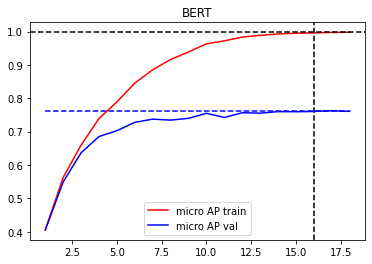

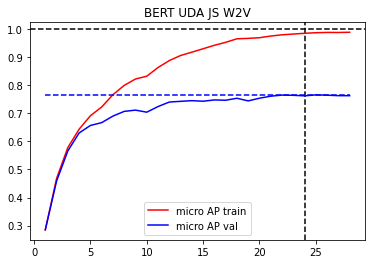